### Introduction

Main idea:

1. Start with an input image $x$ and a target class $y$.
2. Compute the gradient of the loss function (with true target class) with respect to the input image $x$.
3. Make a small update $\epsilon$ to the input image $x$ to slightly change the output of the model.
4. Update equation: $x_{adv} = x + \epsilon \cdot sign(\nabla_x J(\theta, x, y))$
5. Repeat step 2-4 until the model is fooled.


Reference: https://www.youtube.com/watch?v=5lFiZTSsp40



In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
# retina display
%config InlineBackend.figure_format = 'retina'

Text(0, 0.5, 'sign(x)')

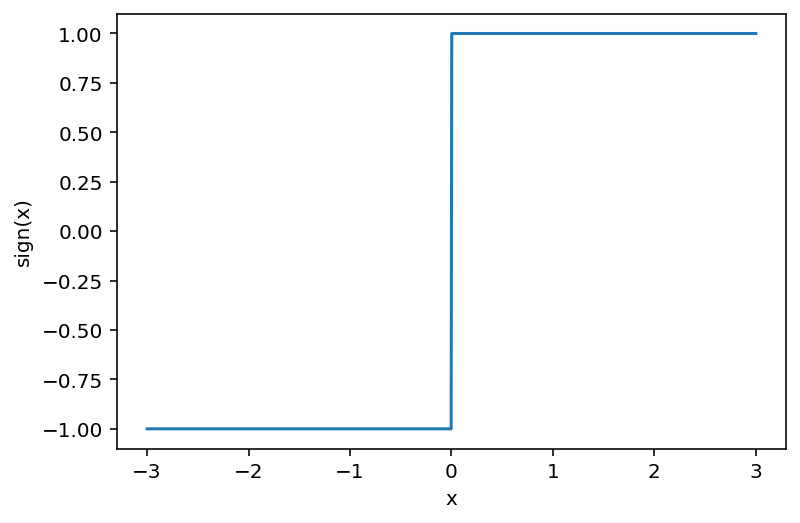

In [67]:
xs = torch.linspace(-3, 3, 1000)
signs = torch.sign(xs)
plt.plot(xs.numpy(), signs.numpy())
plt.xlabel('x')
plt.ylabel('sign(x)')

In [68]:
# Load a pretrained model for imagenet classification
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)

Using cache found in /home/nipun.batra/.cache/torch/hub/pytorch_vision_v0.6.0


In [69]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [70]:
# Put the model in evaluation mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [71]:
# Read in an image and preprocess
from PIL import Image
from torchvision import transforms



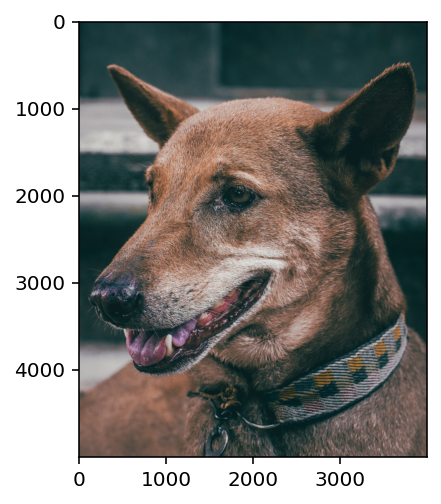

In [72]:
im = Image.open("happy-doggy.jpg")
plt.imshow(im)

In [73]:
# Apply transformations
preprocess_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
img_tensor = preprocess_transforms(im)

/home/nipun.batra/.cache/torch/hub/pytorch_vision_v0.6.0/torchvision/transforms/functional.py:74: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


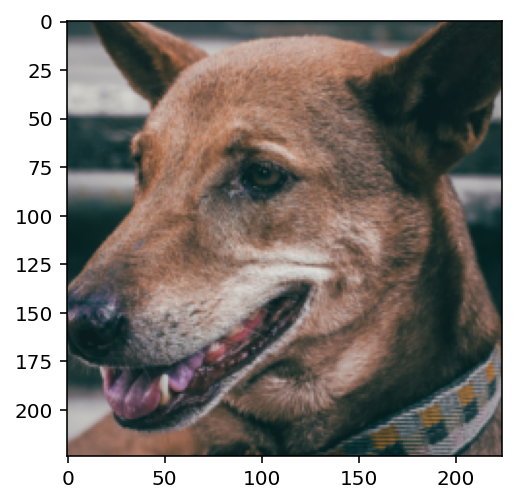

In [74]:
# plot transformed image
plt.imshow(img_tensor.permute(1, 2, 0))

In [75]:
# Add a batch dimension
batched_img_tensor = img_tensor.unsqueeze(0)
batched_img_tensor.shape

torch.Size([1, 3, 224, 224])

In [76]:
# predict the class of the image
preds = model(batched_img_tensor)
preds.argmax()

tensor(273)

In [77]:
# Download imagenet labels
import urllib
url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", "imagenet_classes.txt")
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

# Load ImageNet labels
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
    

In [78]:
categories[preds.argmax()]

'dingo'

In [79]:
def func(inp, model, target):
    out = model(inp)
    loss = torch.nn.functional.nll_loss(out, target=torch.LongTensor([target]))

    print(f"Loss: {loss.item()}")
    return loss

In [80]:
func(batched_img_tensor, model, 258), func(batched_img_tensor, model, 263)

Loss: 1.7196619510650635
Loss: -5.548308372497559


(tensor(1.7197, grad_fn=<NllLossBackward0>),
 tensor(-5.5483, grad_fn=<NllLossBackward0>))

In [81]:
# Get the gradient of the output with respect to an image
def get_gradient(image_tensor, label_idx):
    # Make sure the image requires a gradient.
    image_tensor.requires_grad_(True)
    # Forward pass
    preds = model(image_tensor)
    # Get the gradient of the output with respect to the inputs based on NLL
    loss = torch.nn.functional.nll_loss(preds, target=torch.LongTensor([label_idx]))
    loss.backward()
    print(f"Loss: {loss.item()}")
    image_tensor.requires_grad_(False)
    return image_tensor.grad.data


In [82]:
grads = get_gradient(batched_img_tensor, preds.argmax())
grads.shape

Loss: -12.811663627624512


torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


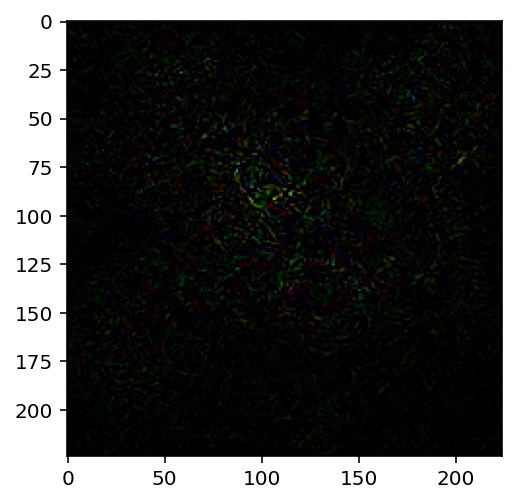

In [83]:
# Plot the gradient
plt.imshow(grads[0].permute(1, 2, 0))

In [84]:
# Get the sign of the gradient
signs = torch.sign(grads)
signs

tensor([[[[-1., -1.,  1.,  ...,  1., -1.,  1.],
          [-1., -1., -1.,  ...,  1.,  1.,  1.],
          [ 1., -1., -1.,  ..., -1.,  1.,  1.],
          ...,
          [-1.,  1., -1.,  ...,  1.,  1.,  1.],
          [-1., -1.,  1.,  ...,  1.,  1.,  1.],
          [-1., -1., -1.,  ..., -1., -1.,  1.]],

         [[-1., -1.,  1.,  ..., -1., -1.,  1.],
          [-1., -1.,  1.,  ..., -1., -1., -1.],
          [ 1., -1., -1.,  ..., -1., -1.,  1.],
          ...,
          [ 1.,  1., -1.,  ...,  1.,  1., -1.],
          [-1., -1.,  1.,  ...,  1.,  1.,  1.],
          [-1.,  1., -1.,  ..., -1., -1.,  1.]],

         [[-1., -1., -1.,  ..., -1., -1.,  1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [ 1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [ 1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1.,  1.,  ...,  1., -1., -1.],
          [-1.,  1., -1.,  ..., -1., -1.,  1.]]]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


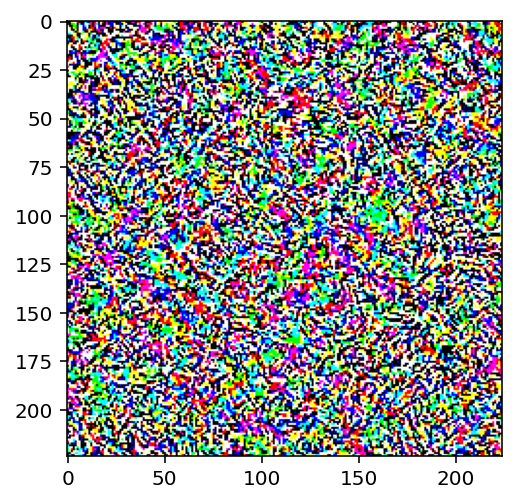

In [85]:
# Plot the sign of the gradient
plt.imshow(signs[0].permute(1, 2, 0))

In [86]:
# Add noise to the image
eps = 0.001
noisy_img = batched_img_tensor + eps * signs
noisy_img = torch.clamp(noisy_img, 0, 1)

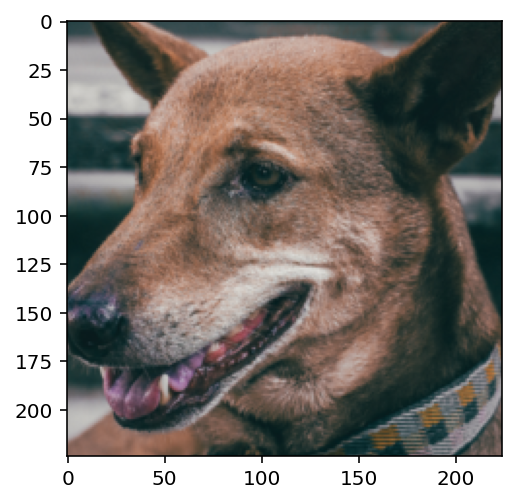

In [87]:
# Plot the noisy image
plt.imshow(noisy_img[0].permute(1, 2, 0))

In [88]:
# view the label for the noisy image
model(noisy_img).argmax()

tensor(434)

In [89]:
# Now, repeat till the model is fooled
eps = 0.0001

noisy_img = batched_img_tensor.clone()
noisy_img.requires_grad_(True)
i = 0
while model(noisy_img).argmax() == preds.argmax():
    grads = get_gradient(noisy_img, preds.argmax())
    signs = torch.sign(grads)
    noisy_img = noisy_img + eps * signs
    noisy_img = torch.clamp(noisy_img, -2, 2)
    noisy_img = noisy_img.detach().requires_grad_(True)
    i = i + 1
    if i % 10 == 0:
        print(i)

# Detach the image tensor from the computation graph
noisy_img.requires_grad_(False)
noisy_img = noisy_img.detach()




Loss: -12.811663627624512
Loss: -12.379142761230469
Loss: -11.94972038269043
Loss: -11.527520179748535


In [90]:
model(noisy_img).argmax()

tensor(173)

In [91]:
categories[model(noisy_img).argmax()]

'Ibizan hound'

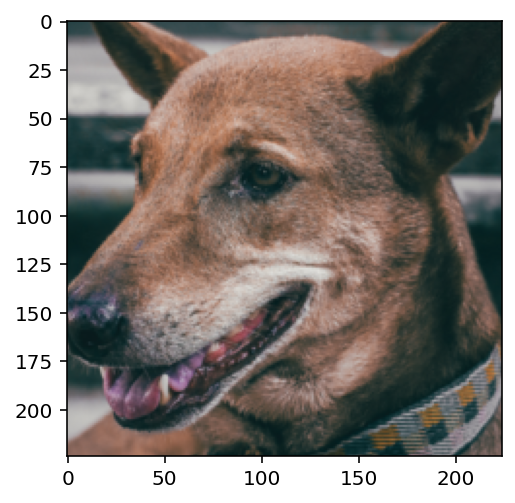

In [92]:
# Plot the image
plt.imshow(noisy_img[0].permute(1, 2, 0))

In [ ]:
# Difference between the original and the adversarial image
diff = (noisy_img - batched_img_tensor)[0]
diff = diff.mean(dim=0)
diff = torch.abs(diff)
diff = diff / diff.max()

In [ ]:
diff.shape

torch.Size([224, 224])

Text(0.5, 1.0, 'Difference')

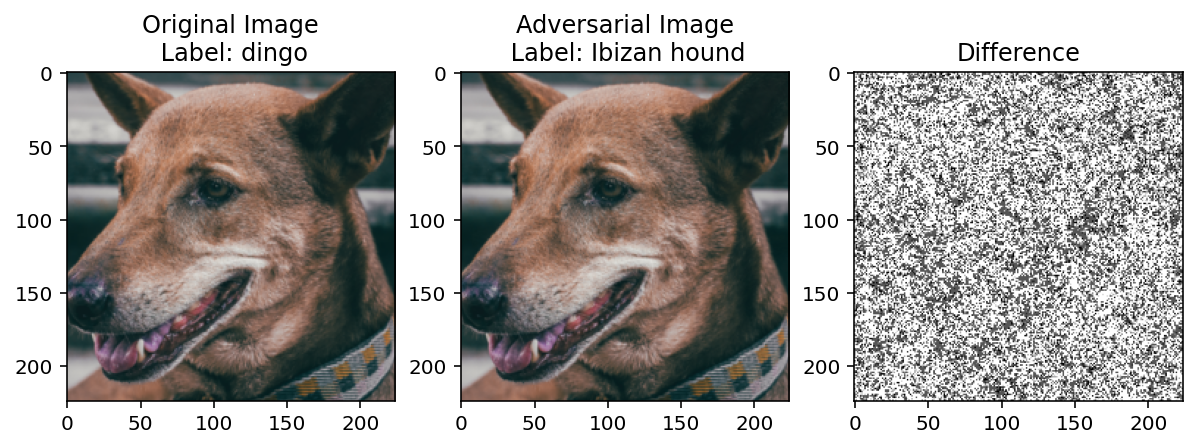

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4), ncols=3)
ax[0].imshow(batched_img_tensor[0].permute(1, 2, 0))
ax[0].set_title("Original Image\n Label: " + categories[preds.argmax()])

ax[1].imshow(noisy_img[0].permute(1, 2, 0))
ax[1].set_title("Adversarial Image\n Label: " + categories[model(noisy_img).argmax()])

ax[2].imshow(diff, cmap='gray')
ax[2].set_title("Difference")

In [108]:
# Now, let us create a function to generate adversarial examples for any image

def generate_adversarial_example(image_tensor, target_label, model, eps=0.001, max_iter=500):
    # Create a noisy image identical to the input image
    noisy_img = image_tensor.clone()
    # Make the noisy image require a gradient
    noisy_img.requires_grad_(True)
    for i in range(max_iter):
        # Get the gradient of the input image
        grads = get_gradient(noisy_img, target_label)
        # Get the sign of the gradient
        signs = torch.sign(grads)
        # Add noise to the image
        noisy_img = noisy_img + eps * signs
        # Clamp the image to make sure it is within the valid pixel range
        noisy_img = torch.clamp(noisy_img, -2, 2)
        # Detach the image tensor from the computation graph
        noisy_img.requires_grad_(False)
        # Check if the noisy image is misclassified
        # Print model prediction
        print(f"Iteration: {i} \t Model Prediction: {categories[model(noisy_img).argmax()]}")
        # If the noisy image is misclassified, return it
        if model(noisy_img).argmax() != target_label:
            return noisy_img
    # If the noisy image is not misclassified within max_iter iterations, return it
    return noisy_img

def plot_image_adversary_difference(image_tensor, noisy_img):
    # Difference between the original and the adversarial image
    diff = (noisy_img - image_tensor)[0]
    diff = diff.mean(dim=0)
    diff = torch.abs(diff)
    diff = diff / diff.max()
    # Plot the image
    fig, ax = plt.subplots(figsize=(10, 4), ncols=3)
    ax[0].imshow(image_tensor[0].permute(1, 2, 0))
    ax[0].set_title("Original Image\n Label: " + categories[model(image_tensor).argmax()])

    ax[1].imshow(noisy_img[0].permute(1, 2, 0))
    ax[1].set_title("Adversarial Image\n Label: " + categories[model(noisy_img).argmax()])

    ax[2].imshow(diff, cmap='gray')
    ax[2].set_title("Difference")

def preprocess(img_path):
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_tensor = preprocess_transforms(img)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

In [109]:
img_path = "lion.jpg"
img_tensor = preprocess(img_path)

/home/nipun.batra/.cache/torch/hub/pytorch_vision_v0.6.0/torchvision/transforms/functional.py:74: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


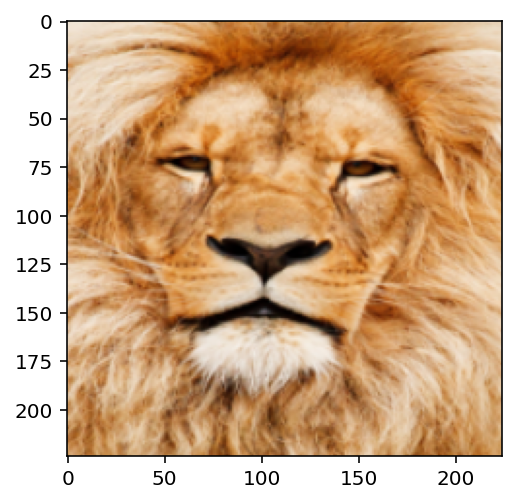

In [110]:
plt.imshow(img_tensor[0].permute(1, 2, 0))

In [111]:
model(img_tensor).argmax()

tensor(291)

In [112]:
categories[model(img_tensor).argmax()]

'lion'

Loss: -17.654619216918945
Iteration: 0 	 Model Prediction: lion
Loss: -17.16172981262207
Iteration: 1 	 Model Prediction: lion
Loss: -16.668292999267578
Iteration: 2 	 Model Prediction: lion
Loss: -16.1711483001709
Iteration: 3 	 Model Prediction: lion
Loss: -15.673859596252441
Iteration: 4 	 Model Prediction: lion
Loss: -15.182080268859863
Iteration: 5 	 Model Prediction: lion
Loss: -14.688620567321777
Iteration: 6 	 Model Prediction: lion
Loss: -14.19030475616455
Iteration: 7 	 Model Prediction: lion
Loss: -13.684654235839844
Iteration: 8 	 Model Prediction: lion
Loss: -13.176743507385254
Iteration: 9 	 Model Prediction: lion
Loss: -12.678997993469238
Iteration: 10 	 Model Prediction: lion
Loss: -12.19263744354248
Iteration: 11 	 Model Prediction: lion
Loss: -11.708401679992676
Iteration: 12 	 Model Prediction: lion
Loss: -11.224825859069824
Iteration: 13 	 Model Prediction: lion
Loss: -10.733859062194824
Iteration: 14 	 Model Prediction: lion
Loss: -10.247729301452637
Iteration: 15 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Loss: -7.380602836608887
Iteration: 21 	 Model Prediction: lion
Loss: -6.926629066467285
Iteration: 22 	 Model Prediction: shield


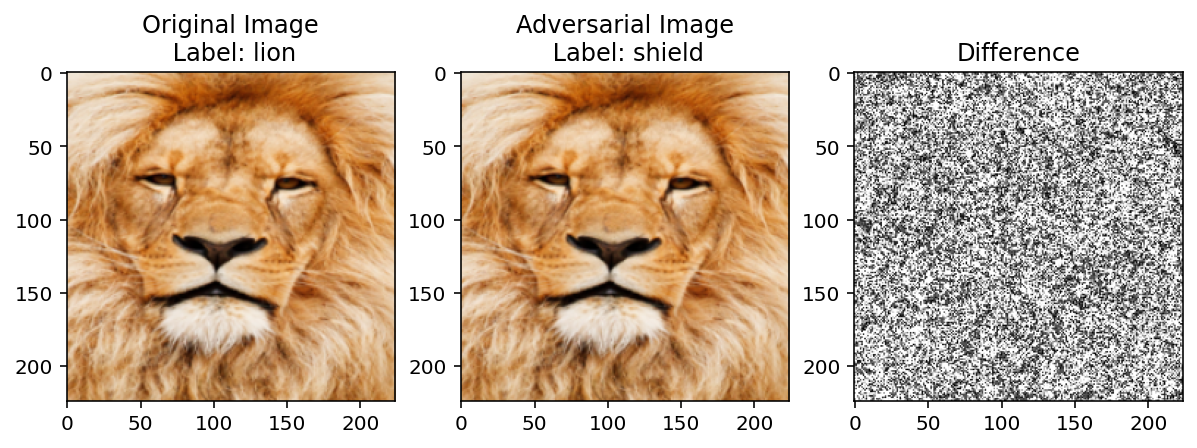

In [114]:
adv = generate_adversarial_example(img_tensor, model(img_tensor).argmax(), model, eps=0.0001, max_iter=50)

plot_image_adversary_difference(img_tensor, adv)


/home/nipun.batra/.cache/torch/hub/pytorch_vision_v0.6.0/torchvision/transforms/functional.py:74: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))


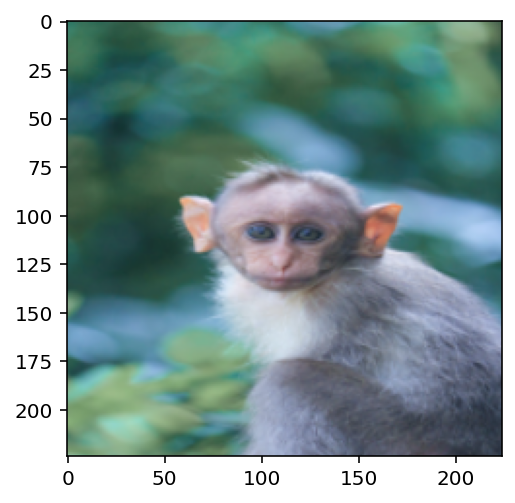

In [115]:
img_path ="monkey.jpg"
img_tensor = preprocess(img_path)

plt.imshow(img_tensor[0].permute(1, 2, 0))


In [116]:
model(img_tensor).argmax()

tensor(373)

In [117]:
categories[model(img_tensor).argmax()]

'macaque'

Loss: -10.831324577331543
Iteration: 0 	 Model Prediction: macaque
Loss: -10.409868240356445
Iteration: 1 	 Model Prediction: macaque
Loss: -9.994575500488281
Iteration: 2 	 Model Prediction: macaque
Loss: -9.579815864562988
Iteration: 3 	 Model Prediction: macaque
Loss: -9.168878555297852
Iteration: 4 	 Model Prediction: macaque
Loss: -8.76225471496582
Iteration: 5 	 Model Prediction: Chihuahua


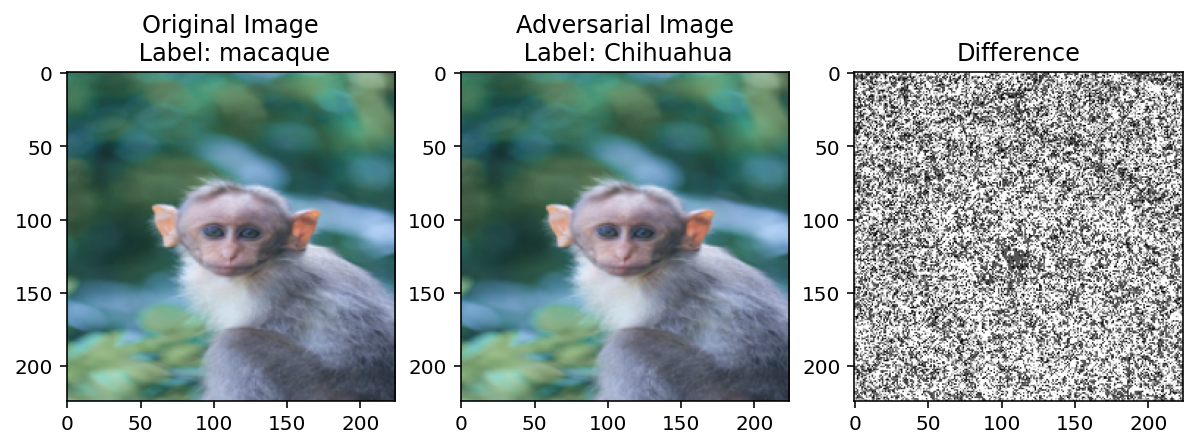

In [118]:
adv = generate_adversarial_example(img_tensor, model(img_tensor).argmax(), model, eps=0.0001, max_iter=50)

plot_image_adversary_difference(img_tensor, adv)